In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)


cuda:0


In [2]:
def inference(model, x, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        out = model(x)
    return out

def generate_left_right_ssc(model, left_img, right_img, device):
    ssc_pred_left = inference(model, build_monoscene_input(left_img), device)
    ssc_pred_left = torch.argmax(ssc_pred_left, dim=1)[0,:,:,:]
    ssc_pred_left = ssc_pred_left.squeeze(0)
    ssc_pred_right = inference(model, build_monoscene_input(right_img), device)
    ssc_pred_right = torch.argmax(ssc_pred_right, dim=1)[0,:,:,:]
    ssc_pred_right = ssc_pred_right.squeeze(0)
    return ssc_pred_left, ssc_pred_right

In [3]:
sys.path.append("/workspace/HKU-OccNet/")
from utils import SemanticKITTIDataset
from utils import visualize_labeled_array3d
from utils import plot_tensor2d
from torch.utils.data import random_split
from utils.monoscene_utils import *

KITTI_DIR = "/workspace/Dataset/dataset"



train_set = SemanticKITTIDataset(root_dir=KITTI_DIR, mode='train', 
                                 sequences=['00'], split_ratio=0.2)


split_idx = int(0.95 * len(train_set))
train_subset, val_subset = random_split(train_set, [split_idx, len(train_set) - split_idx])


num_classes = len(train_set.class_names)
class_weights = train_set.class_weights

img_width, img_height = 1241, 376

print(len(train_subset))  # 训练集子集的长度
print(len(val_subset))    # 验证集子集的长度


calib = read_calib("/workspace/HKU-OccNet/calib.txt")

#get_projections(img_width, img_height, calib)

862
46


In [4]:
from monoscene.monoscene import MonoScene
from utils.monoscene_utils import *

pretrained_weight_path = '/workspace/PretrainedWeights/monoscene_kitti.ckpt'


monoscene_pt = MonoScene.load_from_checkpoint(
        pretrained_weight_path,
        dataset="kitti",
        n_classes=20,
        feature = 64,
        project_scale = 2,
        full_scene_size = (256, 256, 32),
)

def build_monoscene_input(img):
    img = img.unsqueeze(0)
    batch_dict = get_projections(img_width, img_height, calib)
    for key in batch_dict:
        batch_dict[key] = batch_dict[key].unsqueeze(0)
        batch_dict[key] = batch_dict[key].to(device)
    batch_dict["img"] = img.to(device)
    return batch_dict


print("Number of parameters (in millions):", sum(p.numel() for p in monoscene_pt.parameters()) / 1_000_000, 'M')

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/migration/migration.py:200: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  category=PossibleUserWarning,
Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../PretrainedWeights/monoscene_kitti.ckpt`


n_relations 4
Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.
Number of parameters (in millions): 149.555444 M


In [5]:
left_img, right_img, voxel_labels = train_set.__getitem__(666)

In [6]:
# #device = 'cpu'
# ssc_pred_left = inference(monoscene_pt, build_monoscene_input(left_img), device)
# ssc_pred_left = torch.argmax(ssc_pred_left, dim=1)[0,:,:,:]
# ssc_pred_left = ssc_pred_left.squeeze(0)
# visualize_labeled_array3d(ssc_pred_left.cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

In [7]:
# #device = 'cpu'
# ssc_pred_right = inference(monoscene_pt, build_monoscene_input(right_img), device)
# ssc_pred_right = torch.argmax(ssc_pred_right, dim=1)[0,:,:,:]
# ssc_pred_right = ssc_pred_right.squeeze(0)
# visualize_labeled_array3d(ssc_pred_right.cpu().numpy().astype(np.uint16), size = 0.5, marker = 'box')

In [8]:
left_ssc, right_ssc = generate_left_right_ssc(monoscene_pt, left_img, right_img, device)
print(left_ssc.shape)
print(right_ssc.shape)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/workspace/HKU-OccNet/monoscene/monoscene.py:100: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  projected_pix // scale_2d,
/workspace/HKU-OccNet/monoscene/monoscene.py:107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  projected_pix // sca

torch.Size([256, 256, 32])
torch.Size([256, 256, 32])


In [9]:
voxel_labels.shape

torch.Size([256, 256, 32])

In [10]:
left_ssc = left_ssc.cpu()
right_ssc = right_ssc.cpu()
pass

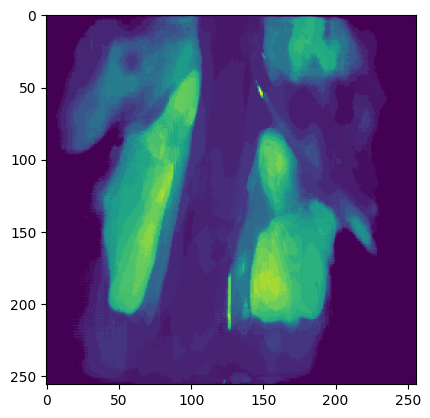

In [11]:
plot_tensor2d(left_ssc.sum(dim=2).unsqueeze(0).cpu())

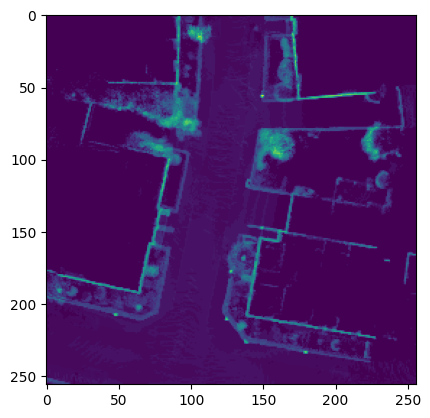

In [12]:
plot_tensor2d(voxel_labels.sum(dim=2).unsqueeze(0).cpu())

In [13]:
voxel_labels.unsqueeze(0).shape

torch.Size([1, 256, 256, 32])

In [14]:
tensor = left_ssc.float()
# Reshape tensor to [256, 1, 256, 32]
tensor_reshaped = tensor.unsqueeze(1)

# Apply average pooling
avg_pooled_tensor = F.avg_pool2d(tensor_reshaped, (1, 32)).squeeze(1)
avg_pooled_tensor = avg_pooled_tensor.permute(2, 0, 1)


In [15]:
avg_pooled_tensor.shape

torch.Size([1, 256, 256])

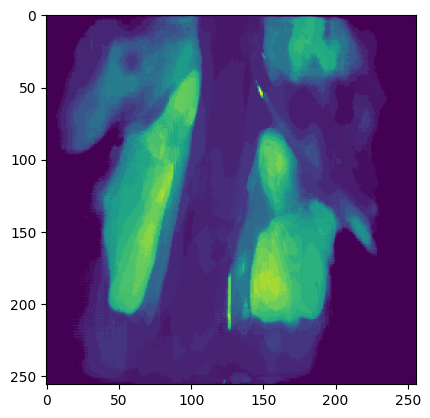

In [16]:
plot_tensor2d(avg_pooled_tensor)

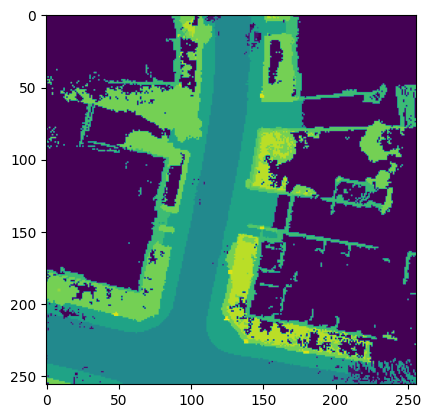

In [17]:
tensor = voxel_labels.float()
# Reshape tensor to [256, 1, 256, 32]
tensor_reshaped = tensor.unsqueeze(1)

# Apply average pooling
max_pooled_tensor = F.max_pool2d(tensor_reshaped, (1, 32)).squeeze(1).permute(2, 0, 1)
plot_tensor2d(max_pooled_tensor)

In [18]:
max_pooled_tensor.shape

torch.Size([1, 256, 256])

In [19]:
# from transformers import DetrFeatureExtractor, DetrForSegmentation


# feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50-dc5-panoptic')
# model = DetrForSegmentation.from_pretrained('facebook/detr-resnet-50-dc5-panoptic')
# print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters()) / 1_000_000, 'M')
# for name, _ in model.named_children():
#     print(name)
# for name, _ in model.detr.named_children():
#     print(name)
    
    
# from collections import OrderedDict
# #new_model = nn.Sequential(*pretrained_model_except_last_layer, your_new_classfier)
# new_model = torch.nn.Sequential(OrderedDict([*(list(model.named_children())[:-2])]))
# new_model.detr = torch.nn.Sequential(OrderedDict([*(list(model.detr.named_children())[:-2])]))
# out = new_model(left_img.unsqueeze(0))
# out.last_hidden_state.shape

In [20]:
import torch
import torch.nn as nn

# Assuming tensor1 and tensor2 are your DETR image features with shape [100, 256]
tensor1 = torch.rand(100, 256)  # e.g., DETR feature 1
tensor2 = torch.rand(100, 256)  # e.g., DETR feature 2

# Reshape tensors to match the [L, N, E] format expected by MultiheadAttention
tensor1 = tensor1.unsqueeze(1)  # Shape becomes [100, 1, 256]
tensor2 = tensor2.unsqueeze(1)  # Shape becomes [100, 1, 256]

# Define the MultiheadAttention layer
num_heads = 8
dropout = 0.1
multihead_attn = nn.MultiheadAttention(embed_dim=256, num_heads=num_heads, dropout=dropout)

# Apply the MultiheadAttention layer
# tensor1 as query, tensor2 as key and value
attn_output, attn_output_weights = multihead_attn(tensor1, tensor2, tensor2)


In [21]:
# # Freeze all layers
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the newly added layers (if any)
# for param in model.fc.parameters():
#     param.requires_grad = True


In [22]:
num_classes = len(train_set.class_names)
class_weights = train_set.class_weights

In [30]:
#!pip install deformable-attention

import torch
import torch.nn as nn
from collections import OrderedDict

from transformers import DetrFeatureExtractor, DetrForSegmentation
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50-dc5-panoptic')
detr_seg_pt = DetrForSegmentation.from_pretrained('facebook/detr-resnet-50-dc5-panoptic')
for param in detr_seg_pt.parameters():
     param.requires_grad = False


import torch
from deformable_attention import DeformableAttention

from utils import sem_scal_loss, geo_scal_loss, CE_ssc_loss

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        # Cross-Attention
        attn_output, _ = self.multihead_attn(query, key_value, key_value)
        # Add & Norm (Residual Connection and Layer Normalization)
        query = self.norm1(query + attn_output)
        return query


class UpsampleBEV(nn.Module):
    def __init__(self):
        super(UpsampleBEV, self).__init__()
        self.initial_fc = nn.Linear(1024, 16*8*8)

        # Upsample and Convolution layers
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(4, 2, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(2, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.initial_fc(x)
        x = x.view(-1, 16, 8, 8)

        # Apply upsampling and convolution layers
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.upsample(x)

        # Adjust channels to 3
        x = self.final_conv(x)
        return x    

# Stereo Forward-Backword BEV Occupancy Prediction Network 
class STF_BEV_Occ(nn.Module):
    def __init__(self, detr_seg_pt):
        super(STF_BEV_Occ, self).__init__()
        # load pretrained detr & remove last layers
        self.detr_seg_pt = detr_seg_pt
        self.detr_seg_pt = torch.nn.Sequential(OrderedDict([*(list(self.detr_seg_pt.named_children())[:-2])]))
        self.detr_seg_pt.detr = torch.nn.Sequential(OrderedDict([*(list(self.detr_seg_pt.detr.named_children())[:-2])]))
        
        
        # out feat shape [1, 100, 256] [100, 256], having 100 elements (like object queries or spatial positions) 
        # for a single sample in the batch, with each element having a feature vector of size 256
        self.backbone = self.detr_seg_pt
        
        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3200, 1024)
        
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(3200, 1024)
        
        self.cross_attn = CrossAttention(embed_dim = 1024, num_heads = 8)
        self.upsample = UpsampleBEV()
    
        self.fc_mse = nn.Linear(256*256*3, 256*256*3)
        self.mse_loss = nn.MSELoss()
    
    #inputs are all in bacthed format
    def forward(self, left_img, right_img): #, depth_disp, sem_seg
        xl = self.backbone(left_img).last_hidden_state
        xl = xl.view(-1, 256, 10, 10)  
        xl = self.relu(self.conv1(xl))
        xl = self.relu(self.conv2(xl))
        xl = self.flatten(xl)
        xl = self.fc1(xl)
        
        #xd = self.backbone(depth)
        
        xr = self.backbone(right_img).last_hidden_state
        xr = xr.view(-1, 256, 10, 10)  
        xr = self.relu(self.conv3(xr))
        xr = self.relu(self.conv4(xr))
        xr = self.flatten(xr)
        xr = self.fc2(xr)
        
        stereo_attn_feat = self.cross_attn(xl, xr)
        x = self.upsample(stereo_attn_feat)
        x = F.max_pool2d(x.permute(0, 2, 3, 1), kernel_size=(1, 3), stride=(1, 3)).permute(0, 3, 1, 2)
        
        
        x = self.flatten(x)
        x = self.fc_mse(x)
        return x
    
    def step(self, left_img, right_img, voxel_labels, class_weights):
        left_img = left_img.to(device)
        right_img = right_img.to(device)
        
        
        tmp = voxel_labels.float().permute(1, 0, 2, 3)
        BEV_labels = max_pooled_tensor = F.max_pool2d(tmp, (1, 32)).permute(1, 3, 0, 2)
        
        
        BEV_labels = BEV_labels.to(device)
        
        BEV_pred = model(left_img, right_img)
        
        
        BEV_labels = BEV_labels.view(-1, 256*256*3)
        loss = self.mse_loss(BEV_pred, BEV_labels)
        
        return loss
        
        

/opt/conda/lib/python3.7/site-packages/transformers/models/detr/feature_extraction_detr.py:31: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  FutureWarning,


In [31]:
model = STF_BEV_Occ(detr_seg_pt)
print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters()) / 1_000_000, 'M')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 model = STF_BEV_Occ(detr_seg_pt)                                                             │
│   2 print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters())      │
│   3                                                                                              │
│                                                                                                  │
│ in __init__:93                                                                                   │
│                                                                                                  │
│    90 │   │   self.cross_attn = CrossAttention(embed_dim = 1024, num_heads = 8)                  │
│    91 │   │   self.upsample = UpsampleBEV()                                                      │
│    92 │   │                                                                                      │
│ ❱  93 │   │   self.fc_mse = nn.Linear(256*256*3, 256*256*3)                                      │
│    94 │   │   self.mse_loss = nn.MSELoss()                                                       │
│    95 │                                                                                          │
│    96 │   #inputs are all in bacthed format                                                      │
│                                                                                                  │
│ /opt/conda/lib/python3.7/site-packages/torch/nn/modules/linear.py:96 in __init__                 │
│                                                                                                  │
│    93 │   │   super(Linear, self).__init__()                                                     │
│    94 │   │   self.in_features = in_features                                                     │
│    95 │   │   self.out_features = out_features                                                   │
│ ❱  96 │   │   self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwarg   │
│    97 │   │   if bias:                                                                           │
│    98 │   │   │   self.bias = Parameter(torch.empty(out_features, **factory_kwargs))             │
│    99 │   │   else:                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: [enforce fail at alloc_cpu.cpp:66] . DefaultCPUAllocator: can't allocate memory: you tried to 
allocate 154618822656 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
left_img, right_img, voxel_labels = train_set.__getitem__(666)
out = model(left_img.unsqueeze(0), right_img.unsqueeze(0))

In [ ]:
out.shape

In [ ]:
train_dataloader = DataLoader(train_subset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=1, shuffle=True)



print(len(train_dataloader))
print(len(val_dataloader))
model = model.to(device)

In [ ]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 3
best_loss = np.inf

In [32]:
from tqdm import tqdm
import torch.nn.functional as F
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (left_img, right_img, voxel_labels) in tqdm(enumerate(train_dataloader),total = len(train_dataloader)):

        loss = model.step(left_img, right_img, voxel_labels, class_weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    with torch.no_grad():
        for (left_img, right_img, voxel_labels) in tqdm(val_dataloader):
            loss = model.step(left_img, right_img, voxel_labels,class_weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), 'bevocc.pth')
        best_loss = (train_loss / len(train_dataloader))

  0%|          | 0/862 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 256, 256, 32])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/862 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4 │   train_loss = 0.0                                                                        │
│    5 │   for i, (left_img, right_img, voxel_labels) in tqdm(enumerate(train_dataloader),total    │
│    6 │   │                                                                                       │
│ ❱  7 │   │   loss = model.step(left_img, right_img, voxel_labels, class_weights)                 │
│    8 │   │   optimizer.zero_grad()                                                               │
│    9 │   │   loss.backward()                                                                     │
│   10 │   │   optimizer.step()                                                                    │
│                                                                                                  │
│ in step:131                                                                                      │
│                                                                                                  │
│   128 │   │   BEV_labels = BEV_labels.to(device)                                                 │
│   129 │   │                                                                                      │
│   130 │   │   BEV_pred = model(left_img, right_img)                                              │
│ ❱ 131 │   │   loss = self.mse_loss(BEV_pred, voxel_labels)                                       │
│   132 │   │                                                                                      │
│   133 │   │   return loss                                                                        │
│   134                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1130 in _call_impl             │
│                                                                                                  │
│   1127 │   │   # this function, and just call forward.                                           │
│   1128 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1129 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1130 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1131 │   │   # Do not call functions when jit is used                                          │
│   1132 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1133 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:530 in forward                   │
│                                                                                                  │
│    527 │   │   super(MSELoss, self).__init__(size_average, reduce, reduction)                    │
│    528 │                                                                                         │
│    529 │   def forward(self, input: Tensor, target: Tensor) -> Tensor:                           │
│ ❱  530 │   │   return F.mse_loss(input, target, reduction=self.reduction)                        │
│    531                                                                                           │
│    532                                                                                           │
│    533 class BCELoss(_WeightedLoss):                       